# This code gives a procedure that takes as its input a WeatherUnderground station ID.  It puts in a condition request of that station, and grabs a list of the nearby stations.  You can inductively build a data-set of all nearby stations. 


In [26]:
## this allows us to build a C-like `struct' object
from collections import namedtuple
## this allows us to load up web pages and read them
import urllib2
## this is a library for parsing JSON files.  JSON stands for JavaScript Object Notation. It
## is a common ASCII text file for describing structured data. 
import json
## we will need to put delays in between our requests to web pages.  Popular web-pages
## will block your access if you request too much data too quickly.
import time 

In [27]:
## These routines need a Weather Underground API.  You will need to request one from the Weather Underground webpage
## to do your own scraping. If you use my one below, you will quickly be locked out. 
WAPI = "yours.api.key.goes.here"

In [28]:
## "WeatherStructure" is the name of this data type. 
## If X is a WStruct, you can call its attributes by: x.StationID, x.assoc, etc. 
WStruct = namedtuple("WeatherStructure", "StationID assoc neighbourhood city province country lat lon elev time weather temp_c humid wind_string wind_dir wind_deg wind_kph pressure_mb dewpt_c precip_today")
## StationID is the Wunderground station ID code
## assoc is the associated nearby Wunderground station ID's
## neighbourhood is a text string indicating roughly where the station is
## ...

In [29]:
# Keep a list of stations we've already queried
StationsVisited = []
# And a list of stations we've discovered but not queried. 
StationsUnexplored = []
# List of fetched weather stations.
WeatherStationData = []

In [30]:
## Give this routine a station ID, it will return a WStruct associated to the station
def FetchWeather(fStationID):
    URL_string = "http://api.wunderground.com/api/"+WAPI+"/geolookup/conditions/q/pws:"+fStationID+".json"
    print "Fetching weather from station: "+fStationID
    URLobj = urllib2.urlopen(URL_string)
    json_string = URLobj.read()
    parsed_json = json.loads(json_string) ## This creates an index for reading the file
    
    # We will use this dictionary-object to build the retval, a WStruct type. 
    adj_pws_stations = parsed_json['location']['nearby_weather_stations']['pws']['station']
    nearby_stations = [ adj_pws_stations[i]['id'] for i in range(len(adj_pws_stations)) ]
    
    # Return the WStruct
    return WStruct(StationID = fStationID, assoc = nearby_stations, neighbourhood = adj_pws_stations[0]['neighborhood'], city = parsed_json['current_observation']['display_location']['city'], province = parsed_json['current_observation']['display_location']['state_name'], country = parsed_json['current_observation']['display_location']['country'], lat = parsed_json['current_observation']['display_location']['latitude'], lon = parsed_json['current_observation']['display_location']['longitude'], elev = parsed_json['current_observation']['display_location']['elevation'], time = parsed_json['current_observation']['observation_time'], weather = parsed_json['current_observation']['weather'], temp_c = parsed_json['current_observation']['temp_c'], humid = parsed_json['current_observation']['relative_humidity'], wind_string = parsed_json['current_observation']['wind_string'],wind_dir = parsed_json['current_observation']['wind_dir'], wind_deg = parsed_json['current_observation']['wind_degrees'], wind_kph = parsed_json['current_observation']['wind_kph'], pressure_mb = parsed_json['current_observation']['pressure_mb'], dewpt_c = parsed_json['current_observation']['dewpoint_c'], precip_today = parsed_json['current_observation']['precip_today_metric'])
        


In [31]:
WS = FetchWeather("IBRITISH479")
## WUnderground's API requires 6 seconds between each request for data.  So we put in a 7-second delay, to be careful.
time.sleep(6)

Fetching weather from station: IBRITISH479


In [32]:
print WS.StationID, WS.neighbourhood

IBRITISH479 Darcy ln. Cordova bay.


In [33]:
WeatherStationData.append(WS)
StationsVisited.append(WS.StationID)

In [34]:
## Now we run through the associated stations in WS.  If they are not in StationsVisited, we will explore them.
WeatherStationsVisited=[]
for i in range(len(WS.assoc)):
    if WS.assoc[i] not in StationsVisited:
        WSi = FetchWeather(WS.assoc[i])
        WeatherStationData.append(WSi)
        StationsVisited.append(WSi.StationID)
        

Fetching weather from station: IBRITISH339
Fetching weather from station: IBCVICTO45
Fetching weather from station: IBCVICTO28
Fetching weather from station: IBCVICTO3
Fetching weather from station: IBRITISH177
Fetching weather from station: IBCVICTO61
Fetching weather from station: IBCVICTO30
Fetching weather from station: IBCVICTO9
Fetching weather from station: IBCVICTO91
Fetching weather from station: IBRITISH188
Fetching weather from station: IBCVICTO71
Fetching weather from station: IBCVICTO36
Fetching weather from station: IBRITISH243
Fetching weather from station: IBRITISH90
Fetching weather from station: IBCVICTO89
Fetching weather from station: IBCVICTO81
Fetching weather from station: MAV097
Fetching weather from station: IBCVICTO16
Fetching weather from station: IBCVICTO77
Fetching weather from station: IBCVICTO41
Fetching weather from station: IBCVICTO34
Fetching weather from station: IBCVICTO87
Fetching weather from station: IBCVICTO42
Fetching weather from station: IDNS7

In [52]:
## Let's do a plot of altitude vs temperature. 
%matplotlib inline 
## the above forces figures to stay in the browser window. 
from matplotlib import *
import matplotlib.pyplot as plt

In [36]:
xax = [WeatherStationData[i].elev for i in range(len(WeatherStationData))]

In [37]:
yax = [WeatherStationData[i].temp_c for i in range(len(WeatherStationData))]

In [38]:
plt.plot(xax,yax, 'ro')
plt.show()

In [39]:
print xax

[u'154.00000000', u'154.00000000', u'154.00000000', u'9.00000000', u'154.00000000', u'9.00000000', u'60.00000000', u'154.00000000', u'60.00000000', u'60.00000000', u'9.00000000', u'60.00000000', u'9.00000000', u'20.00000000', u'60.00000000', u'9.00000000', u'60.00000000', u'66.00000000', u'154.00000000', u'20.00000000', u'3.00000000', u'9.00000000', u'3.00000000', u'3.00000000', u'66.00000000', u'3.00000000', u'3.00000000', u'3.00000000', u'66.00000000', u'81.00000000', u'-3048.00000000', u'94.00000000', u'81.00000000']


In [40]:
print len(WeatherStationData)

33


In [43]:
for i in range(len(xax)): 
    if (float(xax[i])<0.0): 
        print i

30


In [45]:
del(xax[30])
del(yax[30])

In [53]:
for i in range(len(xax)): 
    if (float(xax[i])<0.0): 
        print i

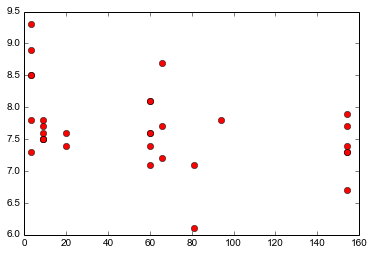

In [54]:
plt.plot(xax,yax, 'ro')
plt.show()